# Pogingen coordinaten hetzelfde te krijgen

Liefst de herschrijving van data waarschijnlijk de `PLT:X`,`Y` waarden in een
enkele coordinatensysteem en `LOC` code, de locaties tabel heeft de `LOC` code,
`LOCOMS` en `LOC:X`,`LOC:Y`.(wellicht lijstje van `PLT:X`,`Y`

In [1]:
import pandas as pd
import numpy as np
import dateutil

In [2]:
df = pd.read_csv("../data/data_tot.csv", encoding='latin1', index_col=0,
                 converters={'DATUM':dateutil.parser.parse})

/home/jasper/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Veel kolommen hebben maar een mogenlijkheid. Algemeen is hoeveelheid mogenlijkheden laag.



`LOC:` en `PLT:` waren identiek in de eerste 10k waarden maar niet meer?

In [3]:
def frac_of(x): return sum(1 for e in x if e)/len(df)

[frac_of(df['LOC:X']!=df['PLT:X']), frac_of(df['LOC:Y']!=df['PLT:Y'])]

[0.23576181247987993, 0.2632035628780175]

In [4]:
[frac_of(df[name].isna()) for name in ('LOC:X','LOC:Y', 'PLT:X','PLT:Y', 'X_WGS','Y_WGS')]

[0.0, 0.0, 0.0, 0.0, 0.003670327186985006, 0.003670327186985006]

Lijkt niet aan het coordinaten systeem te liggen.

In [5]:
print("fractie E50/RD",
      frac_of(df['LOC:COORDSRT']=='E50'), frac_of(df['LOC:COORDSRT']=='RD'))

print("en mismatching",
      frac_of((df['LOC:COORDSRT']=='E50') & (df['LOC:X']!=df['PLT:X'])),
      frac_of((df['LOC:COORDSRT']=='RD') & (df['LOC:X']!=df['PLT:X'])))

fractie E50/RD 0.11952995252196419 0.8804700474780358
en mismatching 0.013326681718078109 0.22243513076180182


In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
nld = gpd.read_file("../doc/data/2018-Waterschappen/2018-Waterschappen.shp")

In [8]:
from pyproj import Proj, transform

# http://epsg.io/23032
inProj = Proj("+proj=utm +zone=32 +ellps=intl +towgs84=-87,-98,-121,0,0,0,0 +units=m +no_defs ") #init='epsg:28992')    # E50 4230
outProj = Proj(init='epsg:4230')  # RD

e50 = df[df['LOC:COORDSRT']=='E50']

aslist = [(*transform(inProj, outProj, x,y), 'E50') for x,y in zip(e50['LOC:X'], e50['LOC:Y'])]

#aslist = [(x*100,y*100, 'E50') for x,y in aslist]

rd = df[df['LOC:COORDSRT']=='RD']

pos_df = pd.DataFrame(aslist + list(zip(rd['PLT:X']/100, rd['PLT:Y']/100)), columns=['X', 'Y', 'what'])

In [9]:
from shapely.geometry import Point
series = gpd.GeoSeries(map(Point, zip(e50['LOC:X'], e50['LOC:Y'])),
                       crs="+proj=utm +zone=32 +ellps=intl +towgs84=-87,-98,-121,0,0,0,0 +units=m +no_defs ")

series = series.to_crs(epsg=28992)

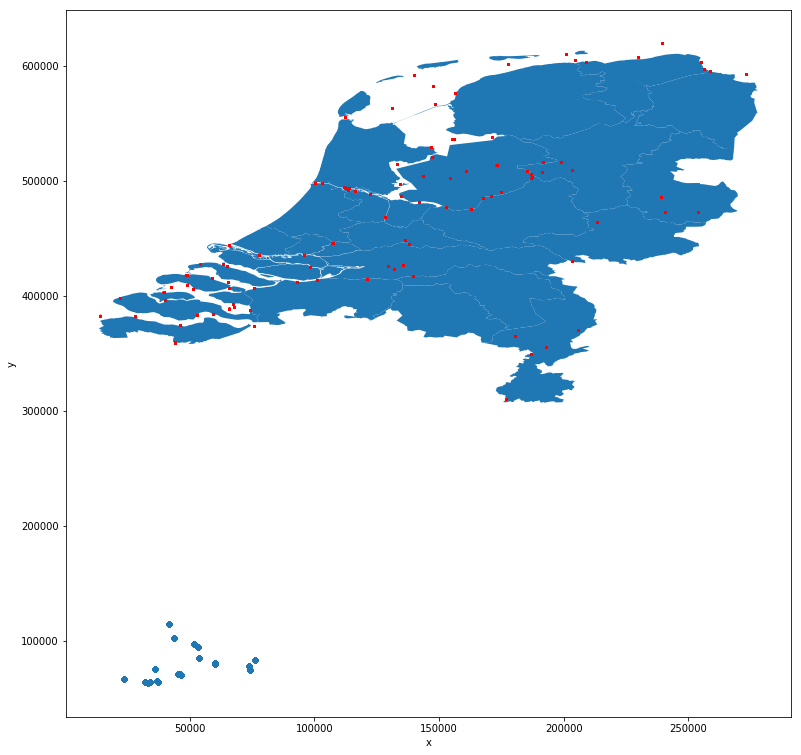

In [10]:
# Plot it.
fig, ax = plt.subplots(figsize=(13,13))
nld.plot(ax=ax)
#pos_df[pos_df.what=='E50'].plot.scatter('X', 'Y', ax=ax, color='green', s=1)
pos_df[pos_df.what!='E50'].plot.scatter('X', 'Y', ax=ax, color='red', s=1)

pd.DataFrame({'x':series.x/100, 'y':series.y/100}).plot.scatter('x','y', ax=ax)

In [11]:
frac_of(df['X_WGS'].isna()), frac_of(df['Y_WGS'].isna())

(0.003670327186985006, 0.003670327186985006)

In [12]:
loc_group = df.groupby('LOC')
loc_df = pd.DataFrame({'X':loc_group['LOC:X'].unique(), 'Y':loc_group['LOC:Y'].unique(),
                       'PLT:X':loc_group['PLT:X'].unique(), 'PLT:Y':loc_group['PLT:Y'].unique(),
                       'X_WGS':loc_group['X_WGS'].unique(), 'Y_WGS':loc_group['Y_WGS'].unique(),
                       'COORDSRT':loc_group['LOC:COORDSRT'].unique()
                      })

# Deze altijd maar een.
def one_variant(lst): return not any(len(e)!=1 for e in lst)

assert(one_variant(loc_df.X)     and one_variant(loc_df.Y))
assert(one_variant(loc_df.X_WGS) and one_variant(loc_df.Y_WGS))

assert(not any(len(e)!=1 for e in loc_df.X))
assert(not any(len(e)!=1 for e in loc_df.Y))

assert(not any(len(e)!=1 for e in loc_df['COORDSRT']))

loc_df.COORDSRT = [cs[0] for cs in loc_df.COORDSRT]  # TODO instead unify them.
loc_df.X = [x[0] for x in loc_df.X]
loc_df.Y = [y[0] for y in loc_df.Y]

loc_df['loc_cnt'] = [len(e) for e in loc_df['PLT:X']]

#loc_df = pd.DataFrame({'LOC':loc_df.index, 'X':[e[0] for e in loc_df.X], 'Y':[e[0] for e in loc_df.Y]})
#loc_df.to_csv("../doc/data/LOC_positions.csv")
#loc_df

In [13]:
loc_df[:4]

COORDSRT                                     PLT:X  \
LOC                                                           
ALMLO          RD                      [23892000, 23893300]   
AMRKHVN2       RD                                [11333000]   
AMSDM          RD  [12221600, 12219100, 12247200, 12221700]   
ANDK           RD                                [14675000]   

                                             PLT:Y         X  \
LOC                                                            
ALMLO                         [48602000, 48605900]  23899000   
AMRKHVN2                                [49175000]  11333000   
AMSDM     [48821000, 48824600, 48830600, 48823100]  12221600   
ANDK                                    [52925000]  14675000   

                         X_WGS         Y                 Y_WGS  loc_cnt  
LOC                                                                      
ALMLO               [6.620117]  48609500  [52.356320000000004]        2  
AMRKHVN2  [4.7747660000000005]  49175000            [52.41199]        1  
AMSDM               [4.905707]  48821000            [52.38077]        4  
ANDK                [5.265018]  52925000  [52.750519999999995]        1

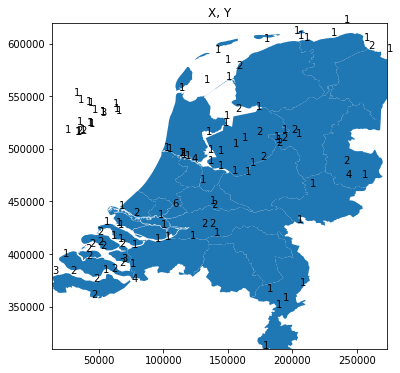

In [14]:
def scatternames(x=None, y=None, name=None, col=None,
                 col_list=['red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'black', 'grey'],
                 ax=None, figsize=(7,4), no_name="+", pre_x=lambda x:x, pre_y=lambda y:y, xlim=None,ylim=None,
                 title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    if xlim is None:
        ax.set_xlim(pre_x(x.min()), pre_x(x.max()))
    elif xlim is not False:  # Manually set.(since have arg anyway.)
        ax.set_xlim(*xlim)

    if ylim is None:
        ax.set_ylim(pre_y(y.min()), pre_y(y.max()))
    elif ylim is not False:
        ax.set_ylim(*ylim)

    # TODO proper dot in some cases.
    for nm,vx,vy in zip(name, x, y):
        px, py = pre_x(vx), pre_y(vy)
        ax.annotate(str(nm) if (nm is not None) else no_name, (px,py),
                    color=col_list[col[i]] if (col is not None) else None)

    if title is None:
        ax.set_title(x.name + ", " + y.name + (" color: " + col if col else ""))
    elif title is not False:
        ax.set_title(title)

    return ax

fig, ax = plt.subplots(figsize=(6,6))
nld.plot(ax=ax)
scatternames(x=loc_df.X/100,y=loc_df.Y/100, name=loc_df.loc_cnt, ax=ax)

#loc_df.plot.scatter('X','Y', ax=ax)